#**A. Introduction**

#**B. Loading dataset**

In [1]:
#importing necessary libraries

#data manipulation and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objects import Layout
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE

#ML libraries
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC ,SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras 
from sklearn.naive_bayes import GaussianNB

#model evaluation libraries
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import matplotlib.gridspec as grid_spec
from sklearn.preprocessing import binarize

#file upload
from google.colab import files
data = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


#**C. Data Preprocessing**

Data preprocessing is a step in the data mining and data analysis process that takes raw data and transforms it to usable form by dropping of data before it is used in order to ensure or enhance performance, and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects.

Some of the data preprocessing techniques are,
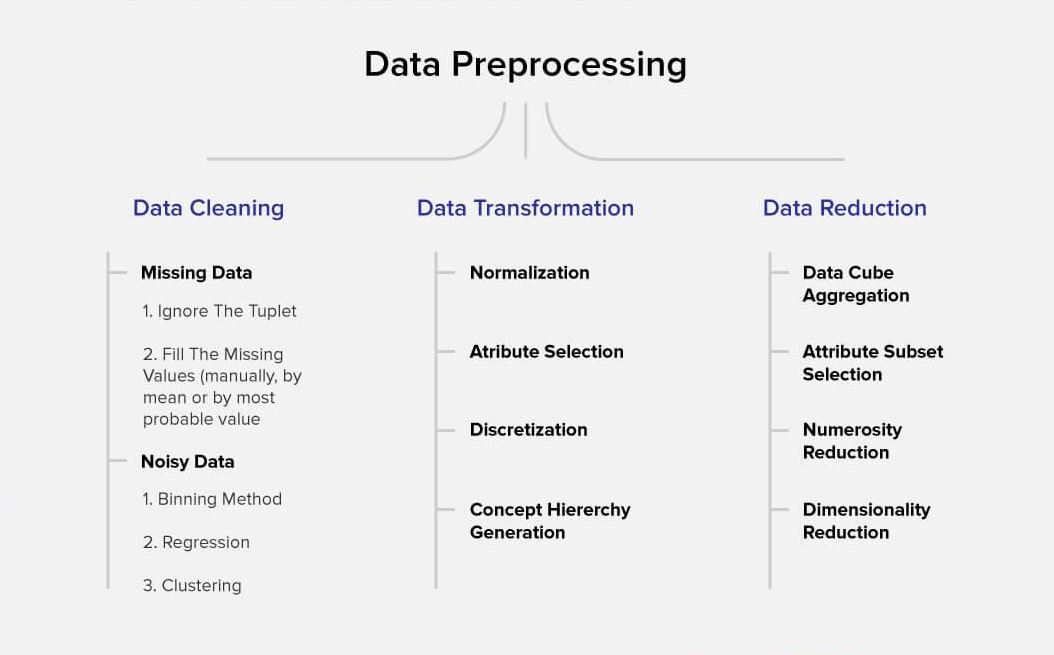

In [17]:
#Reading dataframe
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [18]:
#Our data is of 5110 rows and 13 columns
stroke_df.shape

(5110, 12)

In [19]:
#Checking datatypes of respective features
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

There are 8 categorical variables and 3 numerical variables (age, avg_glucose_level and bmi).

We could notice that age column is in float, as we don't require decimal level precision for calculation, we need to convert age to whole number.
We're also dropping 'ID' column as it doesn't out prediction is not dependent on that feature.

In [20]:
#making necessary manipulations in data
stroke_df['age'] = stroke_df['age'].astype(int)
stroke_df['bmi'] = round(stroke_df['bmi'],2)
stroke_df.drop(columns = 'id', inplace = True)

In [21]:
#Check for duplicates
stroke_df[stroke_df.duplicated()].shape

(0, 11)

No Duplicated data

In [22]:
stroke_df.describe()[1:4].style.background_gradient(cmap='Reds')

In [23]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


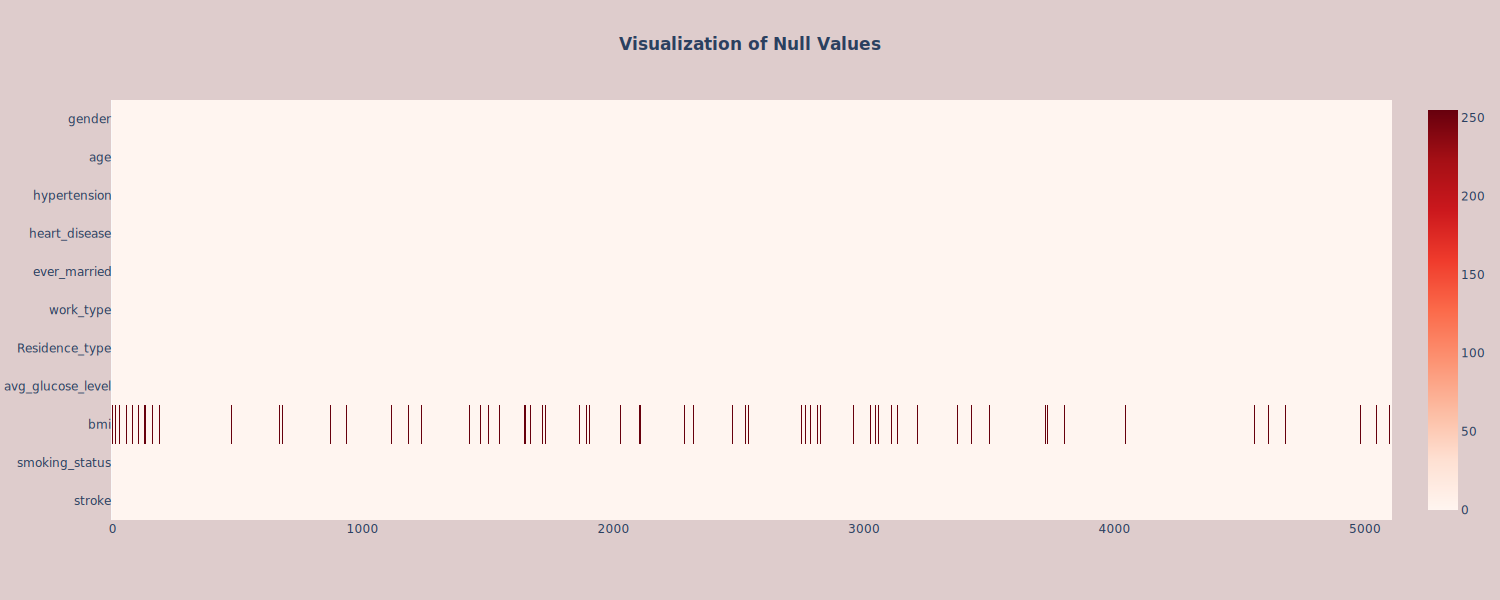

In [28]:
#Check for missing data
fig = px.imshow(stroke_df.isna().transpose(),color_continuous_scale="reds",title="<b>Visualization of Null Values</b>")
fig.update_layout(height=600,width = 1500,paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)',title_x=0.5)
fig.show(renderer="svg")

In [10]:
print('Total Number of Missing Values:',stroke_df['bmi'].isna().sum())

Total Number of Missing Values: 201


Overall there are 5110 records. Only BMI has missing records. There are 201 instances with missing bmi values which is 4% of the dataset.
There are many ways to deal will nullity. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value. We are going to replace the missing records with mean values based on gender distribution


In [11]:
stroke_df.groupby(['gender']).mean()['bmi']

gender
Female    29.065758
Male      28.647936
Other     22.400000
Name: bmi, dtype: float64

There is a patient with gender as other. It is better to remove the instance as only 1 instance has gender as other.

In [12]:
stroke_df = stroke_df.loc[stroke_df["gender"] != 'Other']

In [13]:
#Replacing null values with mean of respective gender
mean_male_bmi = stroke_df.groupby(['gender']).mean()['bmi']['Male']
mean_female_bmi = stroke_df.groupby(['gender']).mean()['bmi']['Female']
stroke_df.loc[stroke_df['gender']=="Male",'bmi']=stroke_df.loc[stroke_df['gender']=="Male"]['bmi'].fillna(mean_male_bmi)
stroke_df.loc[stroke_df['gender']=="Female",'bmi']=stroke_df.loc[stroke_df['gender']=="Female"]['bmi'].fillna(mean_female_bmi)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# binning of numerical variables
stroke_df['bmi_group'] = pd.cut(stroke_df['bmi'], bins = [0,19,25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
stroke_df['age_group'] = pd.cut(stroke_df['age'], bins = [0,13,18,45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
stroke_df['glucose_group'] = pd.cut(stroke_df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

**Initial Insights About Dataset**

*   Data from bmi feature is missing. So we replaced it with median values
*   Both Categorical and numerical features are present.

  1.   Categorical Features: gender, ever_married, work_type, Residence_type, smoking_status
  2.   Binary Numerical Features: hypertension,heart_disease, stroke
  3.   Continous Numerical Features: age, avg_glucose_level, bmi
  4. Feature extraction can be done by binning the continous features ( age, sugar level, and bmi) and let's keep every things as it is.


Most of the data is categorical which need a special attention to visulaize those
Feature extraction can be done by binning the continous features ( age, glucose level, and bmi) and let's keep every other thing as it is.

#**D. Storytelling with Data**

Data storytelling is a popular method to convey most of the information in terms of simple plots rather with complex analysis. This techique's main objective to perform explanatory data analysis rather than exploratory data analysis. All the plots made are as simple as possible with no complications.

In [297]:
#Plotting distribution of feature variables
fig = make_subplots(
    rows=4, cols=2, subplot_titles=("<b>Distribution of patients data based on gender", "<b>Distribution of patients data based on heart disease",
                                    "<b>Distribution of patients data based on marital status", "<b>Distribution of patients data based on location",
                                    "<b>Distribution of patients data based on work style", "<b>Distribution of patients data based on smoking habit",
                                    "<b>Distribution of patients data based on hypertension", "<b>Distribution of patients data based on stroke"),
    specs=[[{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}]],
)


colours = ['#C70039', '#EC7063', '#78281F', '#641E16','#D3D3D3']

fig.add_trace(go.Pie(labels=np.array(stroke_df['gender'].value_counts().index),
                     values=[x for x in stroke_df['gender'].value_counts()],
                     textinfo='label+percent+value', rotation=-45, hole=.35,
                     marker_colors=colours), row=1, col=1)

fig.add_trace(go.Pie(labels=np.array(stroke_df['heart_disease'].value_counts().index),
                     values=[x for x in stroke_df['heart_disease'].value_counts()],
                     textinfo='label+percent+value', hole=.35, rotation = -45,
                     marker_colors=colours), row=1, col=2)

fig.add_trace(go.Pie(labels=np.array(stroke_df['ever_married'].value_counts().index),
                     values=[x for x in stroke_df['ever_married'].value_counts()],
                     textinfo='label+percent+value', hole=.35,
                     marker_colors=colours), row=2, col=1)

fig.add_trace(go.Pie(labels=np.array(stroke_df['Residence_type'].value_counts().index),
                     values=[x for x in stroke_df['Residence_type'].value_counts()],
                     textinfo='label+percent+value', hole=.35,
                     marker_colors=colours), row=2, col=2)

fig.add_trace(go.Pie(labels=np.array(stroke_df['work_type'].value_counts().index),
                     values=[x for x in stroke_df['work_type'].value_counts()],
                     textinfo='label+percent+value', hole=.35,rotation = -45,
                     marker_colors=colours), row=3, col=1)

fig.add_trace(go.Pie(labels=np.array(stroke_df['smoking_status'].value_counts().index),
                     values=[x for x in stroke_df['smoking_status'].value_counts()],
                     textinfo='label+percent+value', hole=.35,
                     marker_colors=colours), row=3, col=2)

fig.add_trace(go.Pie(labels=np.array(stroke_df['hypertension'].value_counts().index),
                     values=[x for x in stroke_df['hypertension'].value_counts()],
                     textinfo='label+percent+value', hole=.35,
                     marker_colors=colours), row=4, col=1)

fig.add_trace(go.Pie(labels=np.array(stroke_df['stroke'].value_counts().index), rotation= -45,
                     values=[x for x in stroke_df['stroke'].value_counts()],
                     textinfo='label+percent+value', hole=.35,
                     marker_colors=colours), row=4, col=2)

fig.update_layout(height=2000, font=dict(size=14), showlegend=False, paper_bgcolor="#DECCCC")
fig.add_annotation(dict(font=dict(color='black',size=15), y=1.04, x=.4, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Overview of Categorical Variables</b>"))
fig.show()

Few insights from above categorical distribution,

**Heart Disease, Hypertension**

*   The data contains more number of people without health disorders than people with disorders.

**Gender, Lifestyle, Smoking Habits**

*   Data is almost equally spread on all categories for the above features

**Stroke**

* From distribution it is clear that every 5 people out of 100 people are 
having strokes from our sampling data. Moreover,this is a highly unbalanced data distribution, and null accuracy score of this distribution it self is 95%, whcih imploys any dump model should randomly predictions of stroke could reach accuracy of 95%. So, while modeling and training data, either over sampling or under sampling has to be done to obtain best results.

## **D.1 Univariate analysis of continuous variables**

In [298]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("<b>Distribution of age by Stroke vs No stroke</b>",
                                    "<b>Distribution of BMI by Stroke vs No stroke</b>",
                                    "<b>Distribution of average glucose level by Stroke vs No stroke</b>", "<b>3D plot of age vs BMI vs glucose</b>"),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "scene"}]],
)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['age'],
    marker_color='#C70039'
    ), row = 1, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['age'],
    marker_color='black'
    ), row = 1, col = 1)


fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['bmi'],
    marker_color='#C70039'
    ), row = 1, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['bmi'],
    marker_color='black'
    ), row = 1, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['avg_glucose_level'],
    marker_color='#C70039'
    ), row = 2, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['avg_glucose_level'],
    marker_color='black', 
    ), row = 2, col = 1)

fig.add_trace(go.Scatter3d(z=stroke_df[stroke_df['stroke']== 0]['age'], x=stroke_df[stroke_df['stroke']== 0]['bmi'],
                           y=stroke_df[stroke_df['stroke']== 0]['avg_glucose_level'], mode="markers", marker_color='#C70039'), 
              row=2, col=2)

fig.add_trace(go.Scatter3d(y=stroke_df[stroke_df['stroke']== 1]['age'], z=stroke_df[stroke_df['stroke']== 1]['bmi'],
                           x=stroke_df[stroke_df['stroke']== 1]['avg_glucose_level'], mode="markers", marker_color='black'), 
              row=2, col=2)

fig.update_layout(height=700, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.15, x=.3, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Overview of Univariate Numerical Variables</b>"))
fig.show()

In [299]:
# f, axes = plt.subplots(1, 3)
# from matplotlib import rc
# #fig = plt.figure(figsize=(20,10))
# #sns.set_theme(style="white")
# plt.rcParams["figure.figsize"] = [20, 7]
# plt.rcParams["figure.autolayout"] = True
# #plt.rcParams['savefig.transparent'] = True
# sns.histplot(stroke_df.age, color="#EC7063", kde= True, ax = axes[0]).set(title='Density distribution of BMI')
# sns.histplot(stroke_df.bmi, color="#EC7063", kde= True, ax = axes[1]).set(title='Density distribution of BMI')
# sns.histplot(stroke_df.avg_glucose_level, color='#EC7063', kde= True, ax = axes[2]).set(title='Density distribution of Average glucose levels')
# sns.set(rc={'axes.facecolor':'#DECCCC','figure.facecolor':'#DECCCC'})
# plt.show()

In [300]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("<b>Age distribution of healthy people</b>","",
                                    "<b>Significance of age on stroke</b>",
                                    "<b>Age distribution of people affected by stroke</b>"),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==0]['age'],
    marker_color='#C70039'
    ), row = 1, col = 1)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==1]['age'],
    marker_color='black'
    ), row = 2, col = 1)
fig.update_traces(orientation='h', side='positive', width=3, points=False)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['age_group'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 2, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['age_group'],texttemplate="%{value}",
    marker_color='black'
), row = 2, col = 2)

fig.update_layout(height=700, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)', violinmode='overlay')

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.05, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Overall Age Distribution</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=1, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Age is an important feature. Age feature distribution is not a normal distriubtion, which needs"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.95, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="to be normalized later. From catergorical features it can be seen that old age people are mostly"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.9, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="having strokes, compared to younger ones. Based on Age we have data from infants to elderly"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.85, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="people. Adult population is the median group."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.80, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Age Stroke Distribution</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.75, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="From stoke Distribution it is clear that aged people are having significant number of strokes."))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.7, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text= " "))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.7, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Impact of Age on stroke</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.63, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Age have significant impact on strokes, and clearly seen that strokes are highest for elderly"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.585, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text= "people and mid age adults, where as negligible for younger people."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.15, x=.35, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Relationship between Heart stroke and Age</b>"))

fig.show()

In [301]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("<b>BMI distribution of healthy people</b>","",
                                    "<b>Significance of BMI on stroke</b>",
                                    "<b>BMI distribution of people affected by stroke</b>"),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==0]['bmi'],
    marker_color='#C70039'
    ), row = 1, col = 1)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==1]['bmi'],
    marker_color='black'
    ), row = 2, col = 1)
fig.update_traces(orientation='h', side='positive', width=3, points=False)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['bmi_group'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 2, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['bmi_group'],texttemplate="%{value}",
    marker_color='black'
), row = 2, col = 2)

fig.update_layout(height=700, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)', violinmode='overlay')

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.05, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Overall Age Distribution</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=1, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="From the plot, it can be seen that Obese and Overweight people are highly likely to get stroke"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.95, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="BMI is highly skewed towards left side, and average bmi is around 30. On the left skewed bmi,"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.9, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Bhigher the bmi rate, higher the possibility of having strokes."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.85, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>BMI Stroke Significance</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.8, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Higher BMI higher chance of stroke."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.75, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Impact of BMI on stroke</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.7, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="High BMI shows signs of possible strokes, and clearly seen that strokes are highest for"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.635, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text= "overweight and obese people, where as negligible for younger people."))
fig.add_annotation(dict(font=dict(color='black',size=15), y=1.15, x=.35, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Relationship between Heart stroke and BMI</b>"))

fig.show()

In [302]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("<b>Glucose level distribution of healthy people</b>","",
                                    "<b>Significance of glucose level on stroke</b>",
                                    "<b>Glucose level distribution of people affected by stroke</b>"),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==0]['avg_glucose_level'],
    marker_color='#C70039'
    ), row = 1, col = 1)

fig.add_trace(go.Violin(
    x=stroke_df[stroke_df['stroke']==1]['avg_glucose_level'],
    marker_color='black'
    ), row = 2, col = 1)
fig.update_traces(orientation='h', side='positive', width=3, points=False)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['glucose_group'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 2, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['glucose_group'],texttemplate="%{value}",
    marker_color='black'
), row = 2, col = 2)

fig.update_layout(height=700, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)', violinmode='overlay')

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.05, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Overall Glucose Distribution</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=1, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Effect of glucose is almost same throughout different levels. Average glucose levels shows"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.95, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="that most of the people have controled glucose levels. However it can be noticed that the"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.9, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="average glucose levels for those healthier and have controled glucose levels are lower compared"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.85, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="to those who got stroke."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.80, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Glucose Stroke Distribution</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.75, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="It is not clear which group of people effected by glucose levels."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=.7, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Impact of glucose on stroke</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.63, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="Glucose does not have significant impact on strokes, and its unclear strokes are which group"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.585, x=.5, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text= "effected by strokes."))

fig.add_annotation(dict(font=dict(color='black',size=15), y=1.15, x=.3, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Relationship between Heart stroke and Glucose Level</b>"))

fig.show()

**Insight**

Based on the above plots, it seems clear that Age is a big factor in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.

Let's explore those variables further...

## **D.2 Visualization of correlations between continuous variables**

In [303]:
#pair plots
df = stroke_df.copy()
df['stroke'] = df['stroke'].astype(str)
fig = px.scatter_matrix(df,
    dimensions=["age", "avg_glucose_level", 'bmi'], height = 1000,
    color="stroke", color_discrete_map = {'0':'#C70039','1':'black'})
fig.update_layout(paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.show()

Based on the graphs above, patients with stroke are overlapping with patients without stroke which indicates that they are not clearly separated.

In [304]:
fig = px.scatter(df, x="age", y="avg_glucose_level", color="stroke", color_discrete_map = {'0':'#C70039','1':'black'}, height = 300, trendline = 'ols')
fig1 = px.scatter(df, x="age", y="bmi", color="stroke", color_discrete_map = {'0':'#C70039','1':'black'}, height = 300, trendline = 'ols')
fig.update_layout(paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig1.update_layout(paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')

fig.add_annotation(dict(font=dict(color='black',size=13), y=-.5, x=.05, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>As we suspected, Age is a big factor, and also has slight relationships with BMI & Avg. Glucose levels. If we notice the trendline, the glucose<b>"))
fig1.add_annotation(dict(font=dict(color='black',size=13), y=1.4, x=.05, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>level for those who got stroke are higher compared to those who did not. Also, with respect to bmi, people who didn't get stroke have balanced<b>"))
fig1.add_annotation(dict(font=dict(color='black',size=13), y=1.3, x=0.05, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>bmi throughout different age distribution compared to those who got. This confirms what our intuitions told us. The older you get, the more at<b>"))
fig1.add_annotation(dict(font=dict(color='black',size=13), y=1.2, x=0.05, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>risk you get.<b>"))
fig.show()
fig1.show()

As we suspected, Age is a big factor, and also has slight relationships with BMI & Avg. Glucose levels. If we notice the trendline, the glucose level for those who got stroke are higher compared to those who did not. Also, with respect to bmi, people who didn't get stroke have balanced bmi throughout different age distributoion compared to those who got. This confirms what our intuitions told us. The older you get, the more at risk you get.



## **D.3 Univariate analysis of Categorical Variables**

In [305]:
fig = make_subplots(
    rows=3, cols=3, subplot_titles=("<b>Risk based on Smoking habits</b>","",'<b>Risk basd on Hypertension</b>',
                                    "<b>Risk based on Marital Status</b>","","<b>Risk based on Residence type</b>"
                                    ,"<b>Risk based on Work type</b>","<b>Risk based on Gender</b>","<b>Risk based on Heart disease</b>"
                                    ),
    specs=[[{"type": "xy"}, {"type": "xy"},{"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"},{"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"},{"type": "xy"}]],
)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['hypertension'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 1, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['hypertension'],texttemplate="%{value}",
    marker_color='black'
    ), row = 1, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['heart_disease'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 3, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['heart_disease'],texttemplate="%{value}",
    marker_color='black'
), row = 3, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['ever_married'],texttemplate="%{value}",
    marker_color='#C70039',
), row = 2, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['ever_married'],texttemplate="%{value}",
    marker_color='black'
), row = 2, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['work_type'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 3, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['work_type'],texttemplate="%{value}",
    marker_color='black'
), row = 3, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['Residence_type'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 2, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['Residence_type'],texttemplate="%{value}",
    marker_color='black'
), row = 2, col = 3)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['smoking_status'],texttemplate="%{value}", 
    marker_color='#C70039'
), row = 1, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['smoking_status'],texttemplate="%{value}",
    marker_color='black'
), row = 1, col = 1)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 0]['gender'],texttemplate="%{value}",
    marker_color='#C70039'
), row = 3, col = 2)

fig.add_trace(go.Histogram(
    x=stroke_df[stroke_df['stroke']== 1]['gender'],texttemplate="%{value}",
    marker_color='black'
), row = 3, col = 2)

fig.add_annotation(dict(font=dict(color='black',size=15), y=1, x=.45, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Insights</b>"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.95, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="  1. Overall Risk of stroke is same irrespective of gender, and"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.92, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      residence type"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.88, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="  2. Risk of stroke for people with hypertension is comparetively"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.85, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      high, nearly 9% more people are having strokes when they"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.82, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      have hypertension."))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.78, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="  3. Risk of stroke for people with heart condition is significant"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.75, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      nearly 12% of people are having strokes when they have"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.72, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      heart condition previously."))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.68, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="  4. Risk of stroke based on smoking habits is interesting one,"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.64, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      it seems smoking does have effect on strokes, and former"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.61, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      smokers are most likely to get strokes."))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.58, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="  5. As per percentages people who are self employed most likely"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.55, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      to have strokes, whereas most of the strokes could be seen"))
fig.add_annotation(dict(font=dict(color='black',size=13), y=.52, x=.31, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="      in privatly employed people."))


fig.update_layout(height=900, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.add_annotation(dict(font=dict(color='black',size=15), y=1.13, x=.33, showarrow=False, textangle=0, xanchor='left', xref="paper", yref="paper", 
                        text="<b>Can we see patterns for Stroke and <br>No Stroke in our data?</b>"))
fig.show()

Overview of the categorical features shows the value counts of the strokes and no strokes for each categorical feature. This overview could give some insight where strokes are high in number.

##**D.4 Relationship between two continuous variables**

In [306]:
stroke = pd.crosstab(stroke_df['gender'],[stroke_df['work_type']],normalize='index').round(4)*100
fig = px.imshow(stroke,color_continuous_scale="reds", text_auto=True)
fig.update_layout(height=600,width = 600,paper_bgcolor="#DECCCC",title = 'Confusion Matrix of Neural Networks')
fig.update_coloraxes(showscale=False)
fig.show()

##**D.5 Visualization of correlations between categorical variables**

Text(7, 6.2, 'A combination of having hypertension and \nheart disease may be a stronger indicator of \nstroke than having either one by itself, so \na person who has both hypertension and heart \ndisease would be at greater risk for stroke than\nsomeone who only has one or the other.')

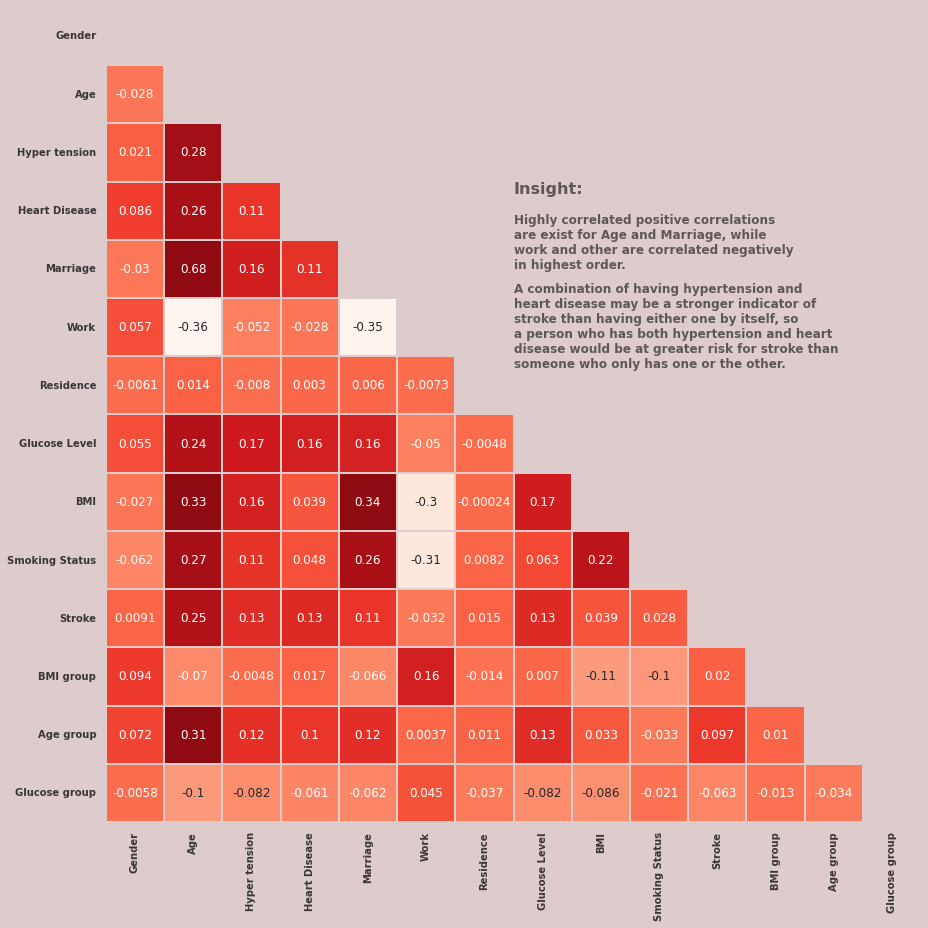

In [307]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
sns.set(rc={'axes.facecolor':'#DECCCC', 'figure.facecolor':'#DECCCC'})


# Generate a large random dataset
stroke_df_corr = stroke_df.copy()
for col in ['ever_married', 'Residence_type','gender','work_type', 'smoking_status',"age_group", "bmi_group","glucose_group"]:
    le = LabelEncoder()
    stroke_df_corr[col] = le.fit_transform(stroke_df_corr[col])

# Compute the correlation matrix
corr = stroke_df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'})
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=.3, center=0,annot=True, cbar = False,linewidth = 1,linecolor = '#DECCCC',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#ticks
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI group','Age group', 'Glucose group']
yticks = ['Gender', 'Age','Hyper tension', 'Heart Disease', 'Marriage', 'Work', 'Residence', 'Glucose Level', 'BMI', 'Smoking Status','Stroke','BMI group','Age group','Glucose group']
ax.set_xticklabels(xticks, {'size':10, 'weight':'bold'},rotation = 90, alpha = 0.9)
ax.set_yticklabels(yticks, {'size':10, 'weight':'bold'}, rotation = 0, alpha = 0.9)
ax.text(7,3.2, 'Insight:',{'size': 16, 'weight':'bold'},alpha = 0.7)
ax.text(7,4.5, 'Highly correlated positive correlations \nare exist for Age and Marriage, while \nwork and other are correlated negatively \nin highest order.',{'size': 12, 'weight':'bold'},alpha = 0.7)
ax.text(7,6.2, 'A combination of having hypertension and \nheart disease may be a stronger indicator of \nstroke than having either one by itself, so \na person who has both hypertension and heart \ndisease would be at greater risk for stroke than\nsomeone who only has one or the other.',{'size': 12, 'weight':'bold'},alpha = 0.7)


In [308]:
le = LabelEncoder()
df_par = stroke_df.copy()
for col in df.select_dtypes(exclude = ['int64', 'float', 'float64', 'int']).columns:
    df_par[col] = le.fit_transform(df_par[col])
fig = px.parallel_coordinates(df_par,color="stroke",
                              color_continuous_scale=px.colors.diverging.Tealrose, title = '<b>Visualization of Multivariate Data</b>')
fig.update_layout( paper_bgcolor="#DECCCC")
fig.show()

## **D.6 Feature Engineering**

Feature engineering is the process that takes raw data and transforms it into features that can be used to create a predictive model using machine learning or statistical modeling, such as deep learning. Algorithms like decision tree can work with categorical data directly with no data transformation required (this depends on the specific implementation). Many machine learning algorithms, instead, require all the input and output variables to be numeric.
In these cases, one-hot encoding or Label encoding comes in help because it transforms categorical data into numerical.

In [309]:
print('\nCategorical Columns\n')
stroke_df.select_dtypes(include=['O']).nunique()
#Hypertension and heart disease is already label encoded


Categorical Columns



gender            2
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

Some categorical columns have 2 unique values, and some have more than 2 unique values.
Here, I will convert the columns with 2 unique values to binary (either 1 or 0)
and one-hot encode the other categorical columns which has more than 2 unique values

In [310]:
#One - hot encoding
# Integer encode columns with 2 unique values
stroke_df_one_hot = stroke_df.copy()
for col in ['ever_married', 'Residence_type','gender']:
    le = LabelEncoder()
    stroke_df_one_hot[col] = le.fit_transform(stroke_df_one_hot[col])
# One-hot encode columns with more than 2 unique values
categorical_features_more_than_2 = ['work_type', 'smoking_status',"age_group", "bmi_group","glucose_group"]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(stroke_df[categorical_features_more_than_2])
cols = encoder.get_feature_names(categorical_features_more_than_2)
stroke_df_one_hot.loc[:, cols] = encoder.transform(stroke_df_one_hot[categorical_features_more_than_2])
# Drop categorical features
stroke_df_one_hot.drop(categorical_features_more_than_2, axis=1, inplace=True)
stroke_df_one_hot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



gender  age  hypertension  heart_disease  ever_married  Residence_type  \
0          1   67             0              1             1               1   
1          0   61             0              0             1               0   
2          1   80             0              1             1               0   
3          0   49             0              0             1               1   
4          0   79             1              0             1               0   
...      ...  ...           ...            ...           ...             ...   
5105       0   80             1              0             1               1   
5106       0   81             0              0             1               1   
5107       0   35             0              0             1               0   
5108       1   51             0              0             1               0   
5109       0   44             0              0             1               1   

      avg_glucose_level        bmi  stroke  work_type_Never_worked  ...  \
0                228.69  36.600000       1                     0.0  ...   
1                202.21  29.065758       1                     0.0  ...   
2                105.92  32.500000       1                     0.0  ...   
3                171.23  34.400000       1                     0.0  ...   
4                174.12  24.000000       1                     0.0  ...   
...                 ...        ...     ...                     ...  ...   
5105              83.75  29.065758       0                     0.0  ...   
5106             125.20  40.000000       0                     0.0  ...   
5107              82.99  30.600000       0                     0.0  ...   
5108             166.29  25.600000       0                     0.0  ...   
5109              85.28  26.200000       0                     0.0  ...   

      age_group_Elderly  age_group_Mid Adults  age_group_Teens  age_group_nan  \
0                   1.0                   0.0              0.0            0.0   
1                   1.0                   0.0              0.0            0.0   
2                   1.0                   0.0              0.0            0.0   
3                   0.0                   1.0              0.0            0.0   
4                   1.0                   0.0              0.0            0.0   
...                 ...                   ...              ...            ...   
5105                1.0                   0.0              0.0            0.0   
5106                1.0                   0.0              0.0            0.0   
5107                0.0                   0.0              0.0            0.0   
5108                0.0                   1.0              0.0            0.0   
5109                0.0                   0.0              0.0            0.0   

      bmi_group_Obesity  bmi_group_Overweight  bmi_group_Underweight  \
0                   1.0                   0.0                    0.0   
1                   0.0                   1.0                    0.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    0.0   
4                   0.0                   0.0                    0.0   
...                 ...                   ...                    ...   
5105                0.0                   1.0                    0.0   
5106                1.0                   0.0                    0.0   
5107                1.0                   0.0                    0.0   
5108                0.0                   1.0                    0.0   
5109                0.0                   1.0                    0.0   

      glucose_group_Low  glucose_group_Normal  glucose_group_Very High  
0                   0.0                   0.0                      0.0  
1                   0.0                   0.0                      0.0  
2                   0.0                   1.0                      0.0  
3             

##**D.7 Feature Extraction**

**Feature Importance Ranking Using Deviance (Logistic Regression) & Random Forest Classifier**

Feature ranking is required to determine the ordering of the features and best set of the features to be used in the model. 

The methods which are to be used for Feature Importance Ranking:

Deviance ranking: Generate deviance for each feature to determine the goodness of fit using probablistic model. The lower the deviance, the better the goodness-of-fit. However, the deviance ranking is only looking at a single independent variable at a time.

Decision Tree: This model can generate multiple decision trees and the features can be ranked based on how many trees have used these features to classify the instances with the smallest impurity based on gini index or the smallest classification error.

In [311]:
# logistic regression for feature importance
# Input variables
X = stroke_df_one_hot.drop(columns = ['stroke'])
#target
y = stroke_df_one_hot['stroke']
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
feat_rank_log = []
feat_rank_log = pd.DataFrame(feat_rank_log)
feat_rank_log['features'] = X.columns
feat_rank_log['importance_score'] = np.round(importance, 4)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [312]:
# decision tree for feature importance on a classification problem
# define dataset
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
feat_rank_dt = []
feat_rank_dt = pd.DataFrame(feat_rank_dt)
feat_rank_dt['features'] = X.columns
feat_rank_dt['importance_score'] = np.round(importance, 4)

In [313]:
fig = px.bar(feat_rank_log, x='features', y='importance_score',text_auto=True, height = 500, title="<b>Feature Importance Using Logistic Regression</b>")
fig.update_layout(showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)', title_x=0.5)
fig.update_traces(marker_color='#C70039',textposition="outside")
fig.show()
fig = px.bar(feat_rank_dt, x='features', y='importance_score',text_auto=True, height = 500, title="<b>Feature Importance Using Decision Tree</b>")
fig.update_layout(showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)', title_x=0.5)
fig.update_traces(marker_color='#C70039',textposition="outside")
fig.show()

Notice that in logistic ranking the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.
Looking at the graph above, logistic ranking shows that the derived variables can explain the likelihood of getting a stroke while feature importance ranking using random forest indicates that the native variables helps predict better likelihood of getting a stroke. Removing ones which has low probability in both models.

In [314]:
less_imp_features = ['work_type_Never_worked','age_group_Teens', 'age_group_nan']
stroke_df_one_hot = stroke_df_one_hot.drop(columns = less_imp_features)

##**D.8 Outlier Analysis**

All data imputation involving calculating mean, median, outlier removal, z-score standarization etc. has to be done after train-test split, otherwise the data may run into a data leakage issue. Also, the outliers should be removed only from train data.

The train-test split is used to estimate the performance of machine learning algorithms that are applicable for prediction-based Algorithms/Applications. This method is a fast and easy procedure to perform such that we can compare our own machine learning model results to machine results.

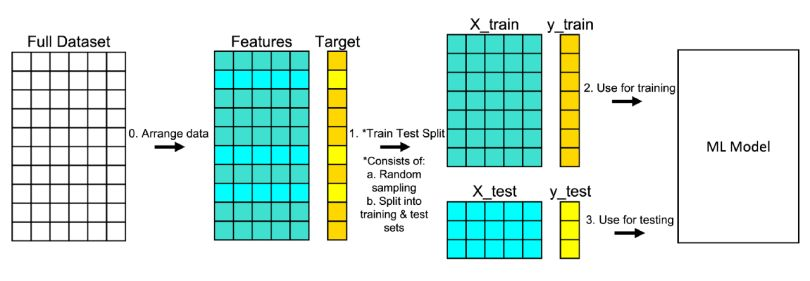

In [315]:
#Splitting train and test data
#input X
X = stroke_df_one_hot.drop(columns = ['stroke'])
#target
y = stroke_df_one_hot['stroke']
from sklearn.model_selection import train_test_split
features = np.array(stroke_df_one_hot[[col for col in stroke_df_one_hot.columns if col!='stroke']])
labels = np.array(stroke_df_one_hot['stroke'])
stroke_df_X_train, stroke_df_X_test, stroke_df_y_train, stroke_df_y_test = train_test_split(X, y, test_size= 0.3, random_state= 0)

In [316]:
#Analysing outliers from only train data to avoid over fitting
fig = make_subplots(rows=1, cols=3, 
                    # Set the subplot titles
                    subplot_titles=['Age', 'Avg glucose level', 'BMI'])
#create boxplot visualization of numeric columns
fig.add_trace(go.Box(x=stroke_df_X_train.age, name='', showlegend=False, marker_color = 'indianred'), row=1, col=1)
fig.add_trace(go.Box(x=stroke_df_X_train.avg_glucose_level, name='', showlegend=False, marker_color = 'darkred'), row=1, col=2)
fig.add_trace(go.Box(x=stroke_df_X_train.bmi, name='', showlegend=False, marker_color = 'black'), row=1, col=3)
#config size
fig.update_layout(paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.update_layout(height=400,font_family='Verdana')
#show visualizations
fig.show()

Trimming outliers altogether may result in the removal of a large number of records from your dataset which isn’t desirable in some cases since columns other than the ones containing the outlier values may contain useful information. In such cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values or use Z-score standard deviation method. Here, we are using Z-score to identify outliers instead of raw scores. Z-score is just the number of standard deviations away from the mean that a certain data point is, if the z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier. Z-scores are important because they offer a comparison between two scores that are not in the same normal distribution.

In [317]:
def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    out.sort()
    print(out)
Zscore_outlier(stroke_df_X_train['bmi'])
Zscore_outlier(stroke_df_X_train['avg_glucose_level'])

[51.7, 51.8, 51.9, 52.3, 52.5, 52.7, 52.7, 52.8, 52.8, 52.9, 53.4, 53.5, 53.8, 53.9, 54.1, 54.2, 54.3, 54.6, 54.6, 54.7, 54.7, 54.8, 55.0, 55.0, 55.7, 55.7, 55.7, 55.7, 55.9, 56.0, 56.6, 57.2, 57.2, 57.5, 57.7, 58.1, 60.2, 60.9, 60.9, 61.2, 61.6, 64.4, 71.9, 78.0, 97.6]
[242.3, 242.52, 242.84, 243.5, 243.52, 243.53, 243.59, 243.73, 244.28, 246.34, 246.53, 247.51, 247.97, 248.37, 249.31, 250.2, 250.8, 251.46, 251.6, 251.99, 253.86, 253.93, 254.6, 254.63, 255.17, 256.74, 260.85, 261.67, 263.56, 266.59, 267.6, 267.76, 271.74]


In [318]:
#Removing outlier values which are more than 3 standard deviation
stroke_df_X_train.loc[stroke_df_X_train.bmi >= 51, 'bmi'] = 51
stroke_df_X_train.loc[stroke_df_X_train.avg_glucose_level >= 240, 'avg_glucose_level'] = 240

##**D.9 Feature Scaling**

It is important to normalize data AFTER splitting. If you normalize before splitting, the mean and standard deviation used to normalize the data will be based on the full dataset and not the training subset — therefore leaking information about the test or validation sets into the train set.
Here, we're using MinMaxScaler() function to normalize data. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [319]:
#Normalizing data usig MinMax scaler
numerical_features = ['avg_glucose_level', 'bmi', 'age']
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler.fit(stroke_df_X_train[numerical_features])
scaler1.fit(stroke_df_X_test[numerical_features])
stroke_df_X_train.loc[:, numerical_features] = scaler.transform(stroke_df_X_train[numerical_features])
stroke_df_X_test.loc[:, numerical_features] = scaler1.transform(stroke_df_X_test[numerical_features])

##**D.10 Balancing the Imbalanced data**

Applying SMOTE to Address Class Imbalance

From the data exploration stage, we already noticed that there is a huge difference in unique stroke feature count. The problem with training the model with an imbalanced dataset is that the model will be biased towards the majority class only. This causes a problem when we are interested in the prediction of the minority class 

Due to this imablance class size, SMOTE (Synthetic Minority Oversampling Technique) algorithm is used to generate additional samples for minority class using k-nearest neighbour method. Using SMOTE, additional 3230 instances are generated as patients with stroke. To generate repoducible result, seed no 42 is used.

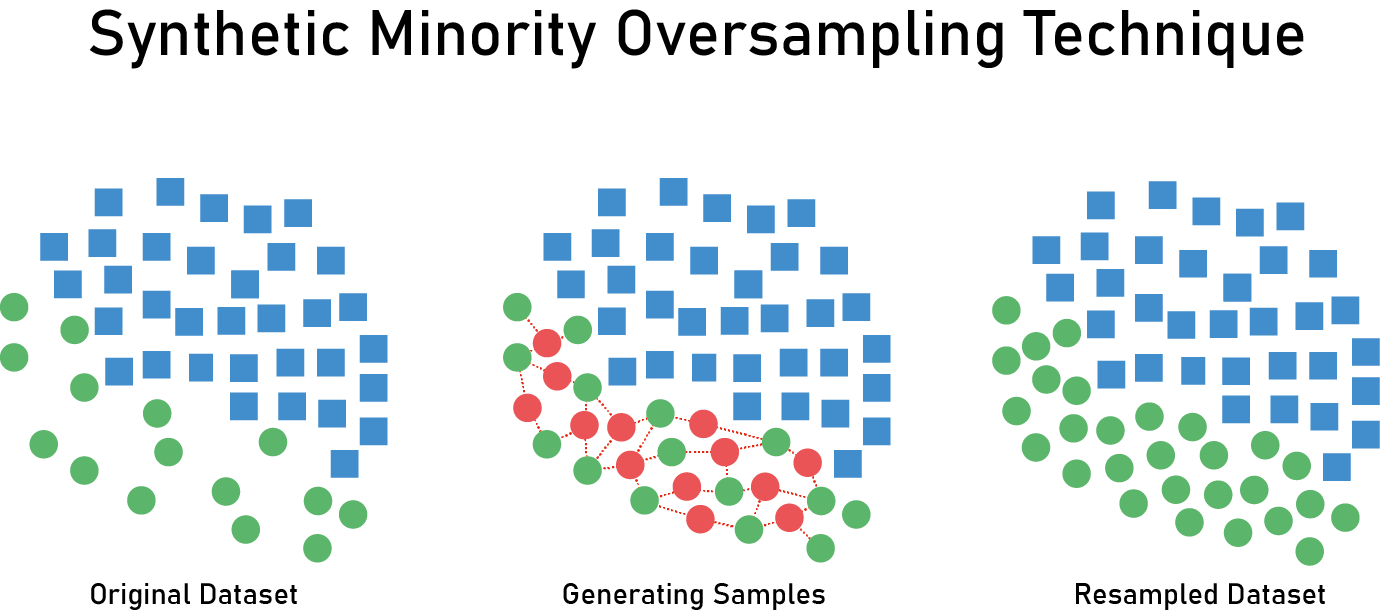

In [320]:
print("Before OverSampling, counts of label '1': {}".format(sum(stroke_df_y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(stroke_df_y_train==0)))

smote=SMOTE(random_state=42)
stroke_df_X_train_smote,stroke_df_y_train_smote=smote.fit_resample(stroke_df_X_train,stroke_df_y_train)

print('After OverSampling, the shape of X train: {}'.format(stroke_df_X_train.shape))
print('After OverSampling, the shape of y train: {} \n'.format(stroke_df_y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(stroke_df_y_train_smote==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(stroke_df_y_train_smote==0)))

print("Before OverSampling, shape of train data: {}".format(stroke_df_X_train.shape))
print("After OverSampling, shape of train data : {}".format(stroke_df_X_train_smote.shape))

Before OverSampling, counts of label '1': 173
Before OverSampling, counts of label '0': 3403 

After OverSampling, the shape of X train: (3576, 23)
After OverSampling, the shape of y train: (3576,) 

After OverSampling, counts of label '1': 3403
After OverSampling, counts of label '0': 3403 

Before OverSampling, shape of train data: (3576, 23)
After OverSampling, shape of train data : (6806, 23)


Looking at the graphs below, SMOTE manages to generate synthetic data according to the distribution of the original samples. Based on the generated synthetic data, patients with stroke are people aged 40 and above and a smaller number of patients below 40 have strokes.

In [321]:
stroke_df_X_train_act=stroke_df_X_train.copy()
stroke_df_X_train_act["stroke"]=stroke_df_y_train.copy()
stroke_smote = stroke_df_X_train_smote.copy()
stroke_smote['stroke'] = stroke_df_y_train_smote.copy()
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("<b>Actual</b>",
                                    "<b>SMOTE</b>",
                                    "<b>Actual</b>", "<b>SMOTE</b>"),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Scatter(
    x=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 0]['age'],
    y=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 0]['avg_glucose_level'],
    mode="markers", marker_color = '#C70039'
), row = 1, col = 1)

fig.add_trace(go.Scatter(
    x=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 1]['age'],
    y=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 1]['avg_glucose_level'],
    mode="markers", marker_color = 'black'
), row = 1, col = 1)

fig.add_trace(go.Scatter(
    x=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 0]['age'],
    y=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 0]['bmi'],
    mode="markers", marker_color = '#C70039'
), row = 2, col = 1)

fig.add_trace(go.Scatter(
    x=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 1]['age'],
    y=stroke_df_X_train_act[stroke_df_X_train_act['stroke']== 1]['bmi'],
    mode="markers", marker_color = 'black'
), row = 2, col = 1)

fig.add_trace(go.Scatter(
    x=stroke_smote[stroke_smote['stroke']== 0]['age'],
    y=stroke_smote[stroke_smote['stroke']== 0]['avg_glucose_level'],
    mode="markers", marker_color = '#C70039'
), row = 1, col = 2)

fig.add_trace(go.Scatter(
    x=stroke_smote[stroke_smote['stroke']== 1]['age'],
    y=stroke_smote[stroke_smote['stroke']== 1]['avg_glucose_level'],
    mode="markers", marker_color = 'black'
), row = 1, col = 2)

fig.add_trace(go.Scatter(
    x=stroke_smote[stroke_smote['stroke']== 0]['age'],
    y=stroke_smote[stroke_smote['stroke']== 0]['bmi'],
    mode="markers", marker_color = '#C70039'
), row = 2, col = 2)

fig.add_trace(go.Scatter(
    x=stroke_smote[stroke_smote['stroke']== 1]['age'],
    y=stroke_smote[stroke_smote['stroke']== 1]['bmi'],
    mode="markers", marker_color = 'black'
), row = 2, col = 2)


fig.update_xaxes(title_text="Age", row=2, col=1)
fig.update_yaxes(title_text="BMI", row=2, col=1)
fig.update_xaxes(title_text="Age", row=1, col=1)
fig.update_yaxes(title_text="Average glucose level", row=1, col=1)
fig.update_xaxes(title_text="Age", row=2, col=2)
fig.update_yaxes(title_text="BMI", row=2, col=2)
fig.update_xaxes(title_text="Age", row=1, col=2)
fig.update_yaxes(title_text="Average glucose level", row=1, col=2)
fig.update_layout(height=700, showlegend=False, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.show()

#**E. Model selection**

In [155]:
# Null accuracy Score for current data
NUll_acc = round (max(stroke_df_y_test.mean(), 1 - stroke_df_y_test.mean()), 2)

print('Null Accuracy Score for Current Data is {}'.format(NUll_acc))

Null Accuracy Score for Current Data is 0.95


This mean any dump model could randomly predict targets nearly 95% accurate. With implementation of some kind of data sampling should do a better job compared to raw data.
I will model Random Forest, SVM, Decision Tree, Logisitc Regression, Neural Nets and Gaussian Naive Bayes for this classificatioin task. 

First classifier we're modelling is Support Vector Classifer

## **E.1 Support Vector Classifier**

A support vector machine (SVM) is a type of deep learning algorithm that performs supervised learning for classification or regression of data groups.
At first approximation what SVMs do is to find a separating line(or hyperplane) between data of two classes. SVM is an algorithm that takes the data as an input and outputs a line that separates those classes if possible.

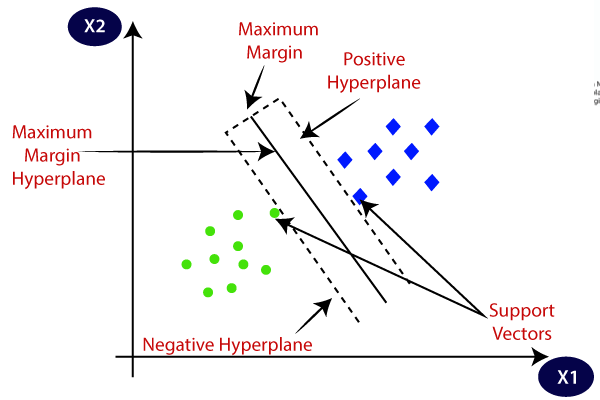

In [156]:
#Support vector Classifier
model_comparison = {}
parameters = {'C': [1,2,3,4,5,6], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svc_model = SVC(probability = True)

svc_clf = GridSearchCV(svc_model, parameters)
print("Searching for best hyperparameters ...")
svc_clf.fit(stroke_df_X_train_smote, stroke_df_y_train_smote)
print(f'Best Hyperparameters: {svc_clf.best_params_}')

y_pred_svc = svc_clf.predict(stroke_df_X_test)
eval_df = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_svc),accuracy_score(stroke_df_y_test, y_pred_svc), recall_score(stroke_df_y_test, y_pred_svc),
                   precision_score(stroke_df_y_test, y_pred_svc), roc_auc_score(stroke_df_y_test, y_pred_svc)]], 
             index=['Support Vector Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
model_comparison['SVC'] = [accuracy_score(stroke_df_y_test,y_pred_svc), f1_score(stroke_df_y_test,y_pred_svc, average='weighted'), recall_score(stroke_df_y_test, y_pred_svc),
                   precision_score(stroke_df_y_test, y_pred_svc), roc_auc_score(stroke_df_y_test, y_pred_svc)]
print('\n')
print(classification_report(stroke_df_y_test,y_pred_svc, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'C': 6, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0      0.957     0.940     0.948      1457
           1      0.139     0.184     0.158        76

    accuracy                          0.903      1533
   macro avg      0.548     0.562     0.553      1533
weighted avg      0.916     0.903     0.909      1533



Decent accuracy, but poor recall. Lets proceed with other models.

##**E.2 Decision Tree Classifier**
The decision tree classifier (Pang-Ning et al., 2006) creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute. Each leaf represents class labels associated with the instance.

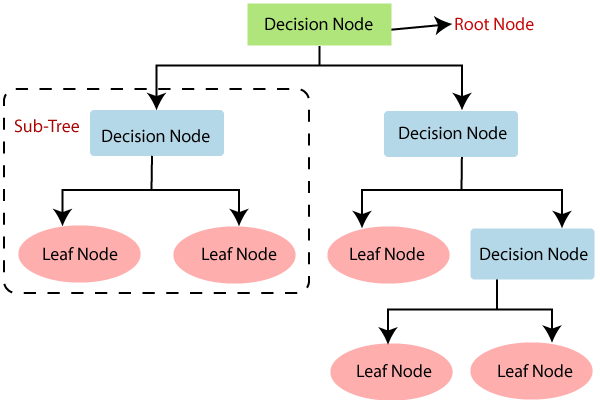

In [157]:
#Decision tree
parameters = {'max_depth': [1,2,3,4,5,6,7,8,9,10]}

Tree_model = DecisionTreeClassifier()

dt_clf = GridSearchCV(Tree_model, parameters)
print("Searching for best hyperparameters ...")
dt_clf.fit(stroke_df_X_train_smote, stroke_df_y_train_smote)
print(f'Best Hyperparameters: {dt_clf.best_params_}')

y_pred_dt = dt_clf.predict(stroke_df_X_test)
eval_df1 = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_dt),accuracy_score(stroke_df_y_test, y_pred_dt), recall_score(stroke_df_y_test, y_pred_dt),
                   precision_score(stroke_df_y_test, y_pred_dt), roc_auc_score(stroke_df_y_test, y_pred_dt)]], 
             index=['Decision Tree Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
eval_df = eval_df.append(eval_df1)
model_comparison['DecisionTreeClassifier'] = [accuracy_score(stroke_df_y_test,y_pred_dt), f1_score(stroke_df_y_test,y_pred_dt, average='weighted'), recall_score(stroke_df_y_test, y_pred_dt),
                   precision_score(stroke_df_y_test, y_pred_dt), roc_auc_score(stroke_df_y_test, y_pred_dt)]
print('\n')
print(classification_report(stroke_df_y_test,y_pred_dt, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 10}


              precision    recall  f1-score   support

           0      0.958     0.918     0.937      1457
           1      0.124     0.224     0.160        76

    accuracy                          0.883      1533
   macro avg      0.541     0.571     0.548      1533
weighted avg      0.916     0.883     0.899      1533



We could notice this models has better accuracy comparing to previous one. Let's explore other models on their performance.

## **E.3 Random Forest**
The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

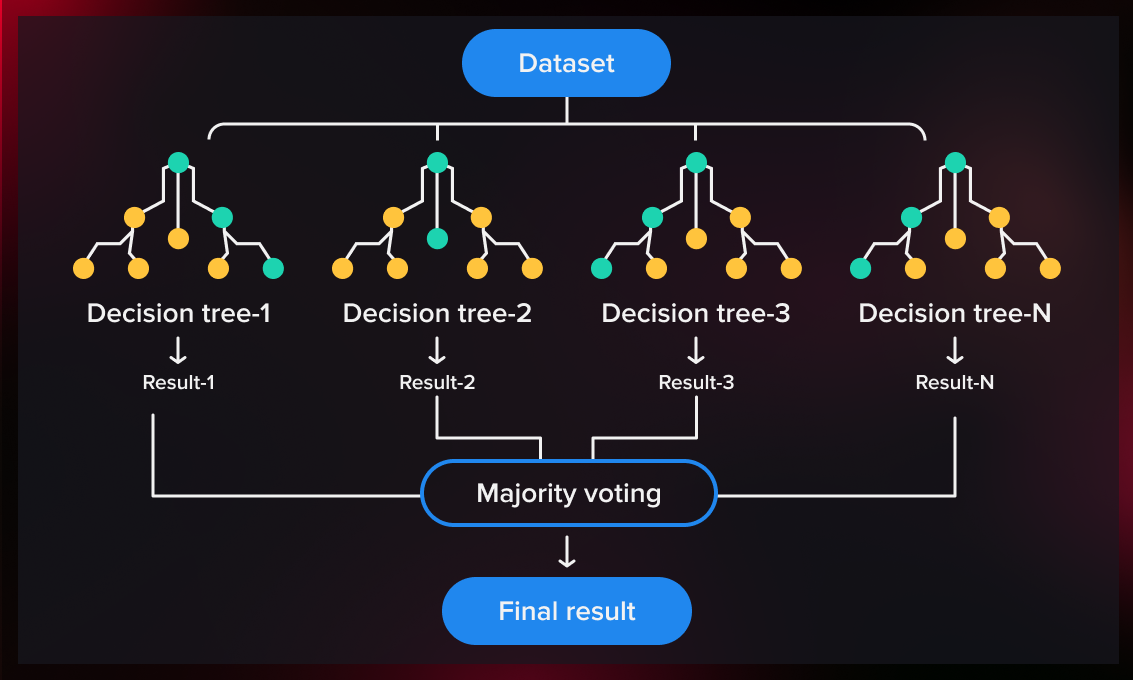

In [158]:
#Random Forest
parameters = {'n_estimators': [50,70], 'max_depth':[6,8]}

rf = RandomForestClassifier()
rf_clf = GridSearchCV(rf, parameters)
print("Searching for best hyperparameters ...")
rf_clf.fit(stroke_df_X_train_smote, stroke_df_y_train_smote)
print(f'Best Hyperparameters: {rf_clf.best_params_}')

y_pred_rf = rf_clf.predict(stroke_df_X_test)
eval_df1 = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_rf),accuracy_score(stroke_df_y_test, y_pred_rf), recall_score(stroke_df_y_test, y_pred_rf),
                   precision_score(stroke_df_y_test, y_pred_rf), roc_auc_score(stroke_df_y_test, y_pred_rf)]], 
             index=['Random Forest Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
eval_df = eval_df.append(eval_df1)
model_comparison['RF'] = [accuracy_score(stroke_df_y_test,y_pred_rf), f1_score(stroke_df_y_test,y_pred_rf, average='weighted'), recall_score(stroke_df_y_test, y_pred_rf),
                   precision_score(stroke_df_y_test, y_pred_rf), roc_auc_score(stroke_df_y_test, y_pred_rf)]

print('\n')
print(classification_report(stroke_df_y_test,y_pred_rf, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 50}


              precision    recall  f1-score   support

           0      0.966     0.898     0.931      1457
           1      0.168     0.395     0.235        76

    accuracy                          0.873      1533
   macro avg      0.567     0.646     0.583      1533
weighted avg      0.926     0.873     0.896      1533



Even though the accuracy is decreasing, having a fair recall score is vital because our goal is to predict the success class. According to this, Random Forest is the best performer thus far.

##**E.4 Logistic Regression**

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

 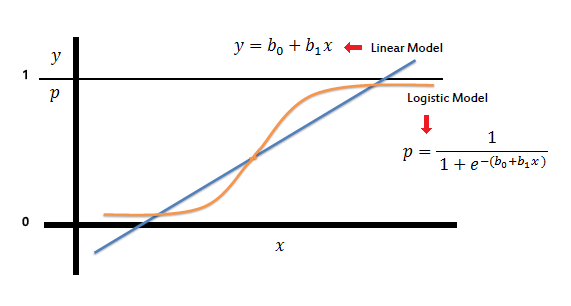

In [159]:
#Logistic Regression
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression()
lr_clf = GridSearchCV(logreg,log_param_grid)
print("Searching for best hyperparameters ...")

#from sklearn.pipeline import Pipeline
#logreg_pipeline = Pipeline(steps = [('LR',LogisticRegression(C=10,penalty='l2',random_state=42))])
lr_clf.fit(stroke_df_X_train_smote,stroke_df_y_train_smote)
print(f'Best Hyperparameters: {lr_clf.best_params_}')
y_pred_logr = lr_clf.predict(stroke_df_X_test)
eval_df1 = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_logr),accuracy_score(stroke_df_y_test, y_pred_logr), recall_score(stroke_df_y_test, y_pred_logr),
                   precision_score(stroke_df_y_test, y_pred_logr), roc_auc_score(stroke_df_y_test, y_pred_logr)]], 
             index=['Logistic Regresssion Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
eval_df = eval_df.append(eval_df1)
model_comparison['LogRegBoost'] = [accuracy_score(stroke_df_y_test,y_pred_logr), f1_score(stroke_df_y_test,y_pred_logr, average='weighted'), recall_score(stroke_df_y_test, y_pred_logr),
                   precision_score(stroke_df_y_test, y_pred_logr), roc_auc_score(stroke_df_y_test, y_pred_logr)]

print(classification_report(stroke_df_y_test,y_pred_logr))


Searching for best hyperparameters ...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Best Hyperparameters: {'C': 100, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      1457
           1       0.13      0.68      0.22        76

    accuracy                           0.75      1533
   macro avg       0.55      0.72      0.54      1533
weighted avg       0.94      0.75      0.82      1533



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Even though the accuracy for logistic regression got reduced, we could notice that the model's ability to predict success class is better comparing to precious ones. Model correctly predicted almost 70& of stroke patients.

Decent Recall and Decent Accuray.

##**E.5 Neural Networks**
A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. There are three main components: an input later, a processing layer, and an output layer. First, the input is the data entered into the network that is to be analyzed. Second, the processing layer utilizes the data (and prior knowledge of similar data sets) to formulate an expected outcome. That outcome is the third component, and this third component is the desired end product from the analysis.

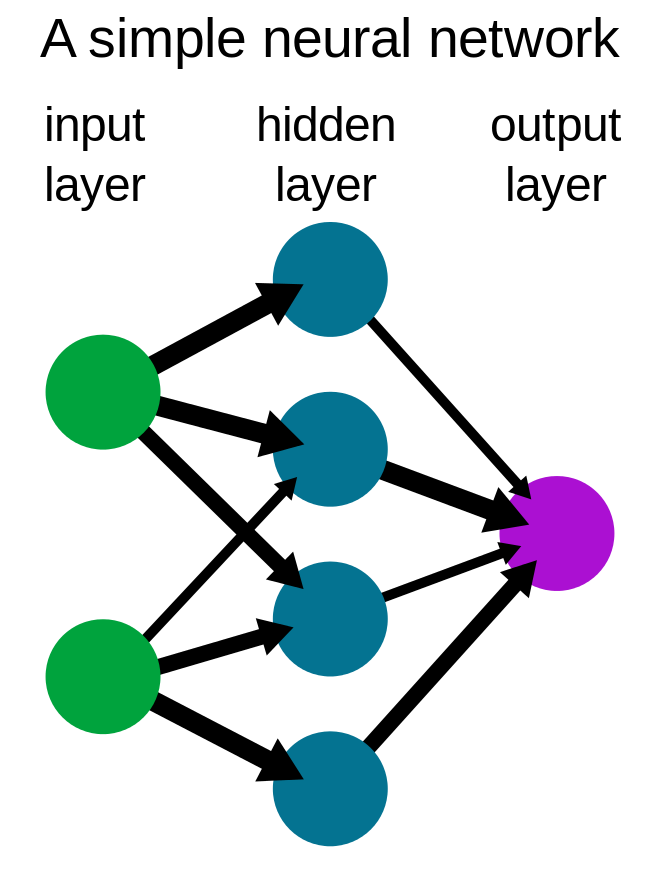


In [160]:
#Neural Network
#We have used 2 hidden layers in our model
inputs = keras.Input(shape=(23,))
a = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.6)(a)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(1, activation='sigmoid')(x)

nn = keras.Model(inputs, output, name="stroke_predictor")
nn.summary()

Model: "stroke_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                1536      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)           

In [205]:
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

#Trains the neural network
history = nn.fit(stroke_df_X_train_smote, stroke_df_y_train_smote, epochs=1000, callbacks=[early_stopper], validation_data=(stroke_df_X_test, stroke_df_y_test), verbose=False)

In [206]:
y_pred_nn = nn.predict(stroke_df_X_test)
threshold = 0.5
y_pred_nn = [1 if i > threshold else 0 for i in y_pred_nn]
eval_df1 = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_nn),accuracy_score(stroke_df_y_test, y_pred_nn), recall_score(stroke_df_y_test, y_pred_nn),
                   precision_score(stroke_df_y_test, y_pred_nn), roc_auc_score(stroke_df_y_test, y_pred_nn)]], 
             index=['NN Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
eval_df = eval_df.append(eval_df1)
model_comparison['NN'] = [accuracy_score(stroke_df_y_test,y_pred_nn), f1_score(stroke_df_y_test,y_pred_nn, average='weighted'), recall_score(stroke_df_y_test, y_pred_nn),
                   precision_score(stroke_df_y_test, y_pred_nn), roc_auc_score(stroke_df_y_test, y_pred_nn)]
print('Test Set Metrics')
print(classification_report(stroke_df_y_test,y_pred_nn, zero_division=1, digits=3))

48/48 [==============================] - 0s 2ms/step
Test Set Metrics
              precision    recall  f1-score   support

           0      0.980     0.747     0.848      1457
           1      0.128     0.711     0.216        76

    accuracy                          0.745      1533
   macro avg      0.554     0.729     0.532      1533
weighted avg      0.938     0.745     0.816      1533



From the metrics, we could see that neural networks provides almost similar performance as Logistic Regression, with accuracy and recall approximately 70%.

##**E.6 Gaussian Naive Bayes Classifier**

In [163]:
#Import Gaussian Naive Bayes model
#Create a Gaussian Classifier
gnb_clf = GaussianNB()

# Train the Classifier/fitting the model
gnb_clf.fit(stroke_df_X_train_smote, stroke_df_y_train_smote)

# predict the response
y_pred_gnb = gnb_clf.predict(stroke_df_X_test)

#Import scikit-learn metrics module for accuracy calculation

eval_df1 = pd.DataFrame(data=[[f1_score(stroke_df_y_test,y_pred_gnb),accuracy_score(stroke_df_y_test, y_pred_gnb), recall_score(stroke_df_y_test, y_pred_gnb),
                   precision_score(stroke_df_y_test, y_pred_gnb), roc_auc_score(stroke_df_y_test, y_pred_gnb)]], 
             index=['Gaussian NB Score'],
             columns=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])
eval_df = eval_df.append(eval_df1)
model_comparison['GNB'] = [accuracy_score(stroke_df_y_test,y_pred_gnb), f1_score(stroke_df_y_test,y_pred_gnb, average='weighted'), recall_score(stroke_df_y_test, y_pred_gnb),
                   precision_score(stroke_df_y_test, y_pred_gnb), roc_auc_score(stroke_df_y_test, y_pred_gnb)]
# evaluate accuracy
print(classification_report(stroke_df_y_test,y_pred_gnb))

              precision    recall  f1-score   support

           0       0.99      0.16      0.28      1457
           1       0.06      0.96      0.11        76

    accuracy                           0.20      1533
   macro avg       0.52      0.56      0.19      1533
weighted avg       0.94      0.20      0.27      1533



That's a huge leap! The model successfully predicts 96% of the success class. However, the accuracy suffers greatly. 
In the following section, we will examine the metrics of data predicted by models and conclude our final model for use.


#**F. Metrics Evaluation**

##**Overview**

So far, beginning with the loading of the dataset we have completed data preparation, feature extraction, numerical feature normalization, feature selection, data exploration, and data modeling. The next stage is to examine all of the trained models and choose the ones that perform the best based on test metrics.

Lets First tabulate the evaluation metrics of all models.

In [166]:
eval_df.style.background_gradient(cmap='Reds')

According to the metrics table, Random Forest has the highest F1 score, Accuracy, and Precision. However, it has a poorer success class prediction rate(recall). When it comes to Logistic Regression, its F1 score and accuracy are nearly same to Random Forest, and it also has a higher Recall and ROC AUC Score. The neural network model acts similarly to Logistic Regression, with the same values across all metrics. Though we focus more on recall rather than accuracy, we can observe that Gaussian Naive Bayes outperforms all other models in terms of recall. That, however, is not the case. The precision and recall for class 0 in the Gaussian NB model are relatively poor, implying that the model predicts the goal value as stroke (class 1) regardless of the data provided as input. This model simply states that given the patient's input data, the model will predict that the patient will have a stroke regardless of his health status. Even while we want the algorithm to identify which patients will have a stroke, predicting every patient and not missing any helps no one.  The trick is to strike a balance between 'hits' and 'misses'.
Hence we'll decide our final model between Logistic Regression and Neural Network model.






##**F.1 Metrics Comparison**

In [ ]:
eval_df.iloc[4:6].style.background_gradient(cmap='Reds')

### **ROC Chart**
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

*   True Positive Rate
*   False Positive Rate


An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

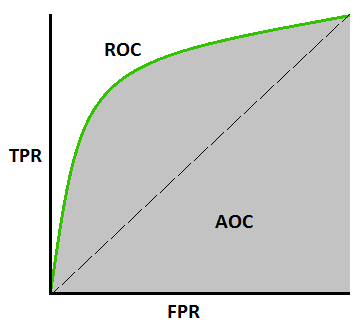


In [191]:
roc_df = pd.DataFrame(columns = ['Classifier', 'True_Positive_Rate', 'False_Positive_Rate'])
#classifiers = ['Logistic Regression', 'Support Vector Classifier', 'Decision Tree', 'Gaussian NB', 'Random Forest']
#clf = [lr_clf, svc_clf, dt_clf, gnb_clf, rf_clf]
#for idx, i in enumerate(clf):
prob = lr_clf.predict_proba(stroke_df_X_test)
prob = prob[:,1]
fpr, tpr, _ = roc_curve(stroke_df_y_test, prob)
roc_df_i = pd.DataFrame(columns = ['Classifier', 'True_Positive_Rate', 'False_Positive_Rate'])
roc_df_i['True_Positive_Rate'] = tpr
roc_df_i['False_Positive_Rate'] = fpr
roc_df_i['Classifier'] = classifiers[idx]
roc_df = pd.concat([roc_df, roc_df_i], ignore_index=True)

prob = [0 for _ in range(len(stroke_df_y_test))]
fpr, tpr, _ = roc_curve(stroke_df_y_test, prob)
roc_df_i = pd.DataFrame(columns = ['Classifier', 'True_Positive_Rate', 'False_Positive_Rate'])
roc_df_i['True_Positive_Rate'] = tpr
roc_df_i['False_Positive_Rate'] = fpr
roc_df_i['Classifier'] = 'Null Chances'
roc_df = pd.concat([roc_df, roc_df_i], ignore_index=True)

prob = nn.predict(stroke_df_X_test) * 100
fpr, tpr, _ = roc_curve(stroke_df_y_test, prob)
roc_df_i = pd.DataFrame(columns = ['Classifier', 'True_Positive_Rate', 'False_Positive_Rate'])
roc_df_i['True_Positive_Rate'] = tpr
roc_df_i['False_Positive_Rate'] = fpr
roc_df_i['Classifier'] = 'Neural Networks'
roc_df = pd.concat([roc_df, roc_df_i], ignore_index=True)

fig = px.line(roc_df, x="False_Positive_Rate", y="True_Positive_Rate", color='Classifier', color_discrete_map = {'Null Chances' : '#EC7063', 'Random Forest':'#000000', 'Neural Networks':'#C70039'})
fig.update_layout(paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.show()

48/48 [==============================] - 0s 2ms/step


###**Hyper Parameter Tuning**

In [ ]:
#Hyperparameter tuning of Logistic Regression
for i in range(1,6):
    
    cm1=0
    y_pred1 = lr_clf.predict_proba(stroke_df_X_test)[:,1]
    y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred1, threshold = i/10)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(stroke_df_y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
           'Classification Report: ', (classification_report(stroke_df_y_test, y_pred2)), '\n\n',
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',          
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[704 753]
 [  6  70]] 

 with 774 correct predictions,  

 Classification Report:                precision    recall  f1-score   support

           0       0.99      0.48      0.65      1457
           1       0.09      0.92      0.16        76

    accuracy                           0.50      1533
   macro avg       0.54      0.70      0.40      1533
weighted avg       0.95      0.50      0.63      1533
 

 Sensitivity:  0.9210526315789473 

 Specificity:  0.48318462594371997 



With 0.2 threshold the Confusion Matrix is  

 [[836 621]
 [  7  69]] 

 with 905 correct predictions,  

 Classification Report:                precision    recall  f1-score   support

           0       0.99      0.57      0.73      1457
           1       0.10      0.91      0.18        76

    accuracy                           0.59      1533
   macro avg       0.55      0.74      0.45      1533
weighted avg       0.95      0.59      0.70      1533
 

 Sens

In [ ]:
#Hyperparameter tuning of Neural Networks

for i in range(1,6):
    
    cm1=0
    y_pred_nn = nn.predict(stroke_df_X_test)

    # y_pred1 = nn.predict_proba(stroke_df_X_test)[:,1]
    # y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred_nn, threshold = i/10)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(stroke_df_y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
           'Classification Report: \n', (classification_report(stroke_df_y_test, y_pred2)), '\n\n',
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',          
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

48/48 [==============================] - 0s 1ms/step
With 0.1 threshold the Confusion Matrix is  

 [[709 748]
 [  5  71]] 

 with 780 correct predictions,  

 Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.49      0.65      1457
           1       0.09      0.93      0.16        76

    accuracy                           0.51      1533
   macro avg       0.54      0.71      0.41      1533
weighted avg       0.95      0.51      0.63      1533
 

 Sensitivity:  0.9342105263157895 

 Specificity:  0.48661633493479756 



48/48 [==============================] - 0s 2ms/step
With 0.2 threshold the Confusion Matrix is  

 [[829 628]
 [  6  70]] 

 with 899 correct predictions,  

 Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.57      0.72      1457
           1       0.10      0.92      0.18        76

    accuracy                           0.59      1533
   macro

##**F.2 Final Model Decision**

So the hyper-parameter tuning has helped both Logisitc Regression and Neural Networks model capture required elements. By manipulating the threshold, we were able to capture stroke data. Both of the model's precision score gained better than Random Forest's - even if the overall acuracy is down. 
One can see how, by manipulating the threshold, we can catch more strokes.

However, one needs to be careful with this approach. We could just change the threshold such that every patient is predicted to have a stroke so as not to miss any - but this helps no one.

F1 score is a decent starting point for this as it is the weighted average of several metrics. F1 score is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it's better to look at both Precision and Recall.

Now we have a decision to make...


So all of our models have quite a high accuracy, the highest being 90% (Support Vector). But the recall of Strokes is quite poor across the board.
The actual selection of model would be up for debate due to the recall variance.

Results always need to be considered carefully - ask yourself: 'Why do I need to predict this value?' In our case, I would assume it would be to offer medical advice / preventative treatment to those we predict will have a stroke, therefore, in the real-world, I would probably select the model with the highest recall. In our case, I chose Logistic Regression / Neural Networks.

The model's can be considered a success - that is, healthcare professionals would be better equipped with this model than without it.

Selection

I would opt for Logistic Regression/Neural Networks.
Both has decent accuracy, and the best recall. I feel that on balance it provides the best overall results.

##**F.3 Logistic Regression Metrics Evaluation**

In [199]:
cm = confusion_matrix(stroke_df_y_test, y_pred_logr)
fig = px.imshow(cm,color_continuous_scale="reds_r", text_auto=True)
fig.update_layout(height=600,width = 800,paper_bgcolor="#DECCCC",title = '<b>Confusion Matrix of Logistic Regression', title_x = 0.5)
fig.show()

In [ ]:
y_scores = lr_clf.predict_proba(stroke_df_X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(stroke_df_y_test, y_scores)

ns_probs = [0 for _ in range(len(stroke_df_y_test))]
lr_probs = lr_clf.predict_proba(stroke_df_X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(stroke_df_y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(stroke_df_y_test, lr_probs)

fig = make_subplots(
    rows= 1, cols=3, subplot_titles=("<b>ROC Curve (AUC = 0.807)", "<b>Precision Vs Recall", "<b>Precision-Recall Curve (AUC=0.155)"),
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Scatter(x=thresholds, y=precisions[:-1], marker_color='black',
                    mode='lines',
                    name='Precision'), row = 1, col = 2)
fig.add_trace(go.Scatter(x=thresholds, y=recalls[:-1], marker_color = '#C70039',
                    mode='lines',
                    name='Recall'), row = 1, col = 2)

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, marker_color='black', line=dict(dash='dash'),
                    mode='lines',
                    name='Random Chances'), row = 1, col = 1)

fig.add_trace(go.Scatter(x=lr_fpr, y=lr_tpr, marker_color = '#C70039',
                    mode='lines',
                    name='ROC Curve for NN'), row = 1, col = 1)

fig.add_trace(go.Scatter(y=precisions, x=recalls, marker_color = '#C70039',
                    mode='lines',
                    name='Recall'), row = 1, col = 3)

fig.add_trace(go.Scatter(y=[1, 0], marker_color='black', line=dict(dash='dash'),
                    mode='lines',
                    name='Random Chances'), row = 1, col = 3)

fig.update_layout(height=450, showlegend=True, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.update_xaxes(title_text="Threshold", row=1, col=2)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="Recall", row=1, col=3)
fig.update_yaxes(title_text="Precision", row=1, col=3)
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.42,
                                        y=1.3,
                                        showarrow=False,
                                        text="<b>Logistic Regression Summary</b>",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()

In [ ]:
print('precision,recall',auc(recalls,precisions))
print('roc',auc(lr_fpr,lr_tpr))

precision,recall 0.15511052988802798
roc 0.807282447711592


##**F.4 Neural Networks Metrics Evaluation**

In [200]:
cm = confusion_matrix(stroke_df_y_test, y_pred2)
fig = px.imshow(cm,color_continuous_scale="reds_r", text_auto=True)
fig.update_layout(height=600,width = 800,paper_bgcolor="#DECCCC",title = '<b>Confusion Matrix of Neural Networks', title_x = 0.5)
fig.show()

In [192]:
nn_prob = nn.predict(stroke_df_X_test)

fpr, tpr, _ = roc_curve(stroke_df_y_test, nn_prob)

#y_scores = lr_clf.predict_proba(stroke_df_X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(stroke_df_y_test, nn_prob)

ns_probs = [0 for _ in range(len(stroke_df_y_test))]
# lr_probs = lr_clf.predict_proba(stroke_df_X_test)
# lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(stroke_df_y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(stroke_df_y_test, nn_prob)

fig = make_subplots(
    rows= 1, cols=3, subplot_titles=("<b>ROC Curve (AUC = 0.803)", "<b>Precision Vs Recall", "<b>Precision-Recall Curve (AUC=0.144)"),
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]],
)

fig.add_trace(go.Scatter(x=thresholds, y=precisions[:-1], marker_color='black',
                    mode='lines',
                    name='Precision'), row = 1, col = 2)
fig.add_trace(go.Scatter(x=thresholds, y=recalls[:-1], marker_color = '#C70039',
                    mode='lines',
                    name='Recall'), row = 1, col = 2)

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, marker_color='black', line=dict(dash='dash'),
                    mode='lines',
                    name='Random Chances'), row = 1, col = 1)

fig.add_trace(go.Scatter(x=nn_fpr, y=nn_tpr, marker_color = '#C70039',
                    mode='lines',
                    name='ROC Curve for NN'), row = 1, col = 1)

fig.add_trace(go.Scatter(y=precisions, x=recalls, marker_color = '#C70039',
                    mode='lines',
                    name='Recall'), row = 1, col = 3)

fig.add_trace(go.Scatter(y=[1, 0], marker_color='black', line=dict(dash='dash'),
                    mode='lines',
                    name='Random Chances'), row = 1, col = 3)

fig.update_layout(height=450, showlegend=True, paper_bgcolor="#DECCCC", plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.update_xaxes(title_text="Threshold", row=1, col=2)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="Recall", row=1, col=3)
fig.update_yaxes(title_text="Precision", row=1, col=3)
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.42,
                                        y=1.3,
                                        showarrow=False,
                                        text="<b>Neural Networks Summary</b>",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()

48/48 [==============================] - 0s 1ms/step


In [ ]:
print('precision,recall',auc(recalls,precisions))
print('roc',auc(nn_fpr,nn_tpr))

precision,recall 0.14439302608089113
roc 0.8036972148972293


#**G. Conclusive Summary**

One of the most significant obstacles of machine learning is a lack of sufficient data. Our dataset comprised about 5000 samples, which is pretty tiny by machine learning standards. The lesson is simply that additional data would increase our metric results. Exposure to a larger dataset would also allow us to conduct a more thorough study and maybe acquire insights that we were unable to obtain with the smaller sample.

Except for accuracy, our results are below average in every category. Even after oversampling our data, it was impossible to create a model that could predict a patient suffering a stroke (our model captures all the persons who have not had a stroke but fails on all instances at predicting ones who did have a stroke). To be adequately performed in a medical scenario, our models require a significant quantity of data to train on in order to reflect the various nature of human biology, nature, and their subsequent behaviors. In an ideal world, everyone would be healthy and free of these ailments, but until that time comes, we would need more data.

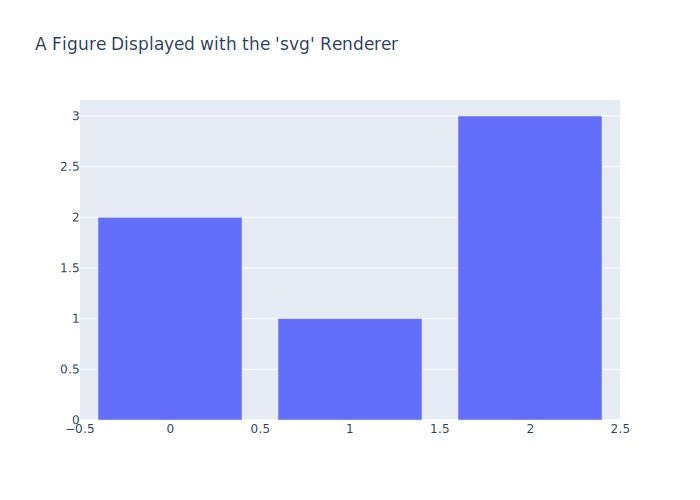

In [15]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with the 'svg' Renderer"
)
fig.show(renderer="svg")